---
# Create LGM lower boundary conditions for CAM7
### Author: Jiang Zhu (jiangzhu@ucar.edu)

* References
  * [PMIP4 LGM protocols: Section 4.1](https://gmd.copernicus.org/articles/10/4035/2017/)
    * CO2 = 190 ppm
    * CH4 = 375 ppm
    * N2O = 200 ppv
    * CFCs = 0
---

In [1]:
import subprocess
import datetime

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf

import warnings
warnings.filterwarnings('ignore')

---
# Input

In [2]:
lbc_dir = '/glade/campaign/cesm/cesmdata/inputdata/atm/waccm/lb'
lbc_file_pre = f"{lbc_dir}/LBC_17500116-20150116_CMIP6_0p5degLat_c180905.nc"
print(lbc_file_pre)

ds_lbc_pre = xr.open_dataset(lbc_file_pre).sel(time="1850")
ds_lbc_pre

/glade/campaign/cesm/cesmdata/inputdata/atm/waccm/lb/LBC_17500116-20150116_CMIP6_0p5degLat_c180905.nc


<xarray.Dataset>
Dimensions:       (lat: 360, lon: 288, time: 12, bounds: 2)
Coordinates:
  * lat           (lat) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * lon           (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time          (time) datetime64[ns] 1850-01-16T12:00:00 ... 1850-12-16T12...
Dimensions without coordinates: bounds
Data variables: (12/30)
    date          (time) int32 ...
    CFCL3_LBC     (time, lat) float32 ...
    CF2CL2_LBC    (time, lat) float32 ...
    CFC113_LBC    (time, lat) float32 ...
    CFC114_LBC    (time, lat) float32 ...
    CFC115_LBC    (time, lat) float32 ...
    ...            ...
    TOT_BROY      (time, lat) float32 ...
    TOT_FOY       (time, lat) float32 ...
    SF6_LBC       (time, lat) float32 ...
    OCS_LBC       (time, lat) float32 ...
    CFC11eq_LBC   (time, lat) float32 ...
    time_bnds     (time, bounds) datetime64[ns] ...
Attributes: (12/14)
    title:                 Time dependent mole fraction surface boundary cond...
    source:                File created by Doug Kinnison, NCAR,  dkin@ucar,edu
    cesm_contact:          Simone Tilmes (tilmes@ucar.edu) and Mike Mills (mi...
    creation_date:         20180227
    data_update:           N/A
    history:               N/A
    ...                    ...
    data_description_url:  https://esgf-node.llnl.gov/search/input4mips/ ; ht...
    data_period:           CMIP6 hindcast (years 17500116 to 20141216); Note:...
    data_resolution:       Data provided at fine 0.5degree latitudinal resolu...
    data_creation_date:    CMIP6: 2016-08-30T18:19:51Z
    data_reference_CMIP6:  Malte Meinshausen, Elisabeth Vogel, Alexander Naue...
    data_reference_OCS:    Montzka, S. A., M. Aydin, M. Battle, J. H. Butler,...

---
# Output

In [3]:
today = datetime.date.today().strftime("%y%m%d")
print(today)

work_dir = '/glade/work/jiangzhu/data/inputdata/cesm3_21ka'
lbc_fname_lgm = f"LBC_1850_pmip5_21ka_0p5degLat_c{today}.nc"

lbc_file_lgm = f"{work_dir}/{lbc_fname_lgm}"
print(lbc_file_lgm)

240518
/glade/work/jiangzhu/data/inputdata/cesm3_21ka/LBC_1850_pmip5_21ka_0p5degLat_c240518.nc


---
# Create the LGM LBC file

In [4]:
ds_lbc_lgm = ds_lbc_pre.copy(deep=True)

coslat = np.cos(np.deg2rad(ds_lbc_lgm.lat))
mon_len = ds_lbc_lgm.time.dt.days_in_month

# Update GHGs and keep the preindustrial seasonal and latitudinal variation
for vname, new_val in zip(['CO2_LBC', 'CH4_LBC', 'N2O_LBC'],
                          (190.0 / 1e6, 375.0 / 1e9, 200.0 / 1e9)):

    ds_lbc_lgm[vname].data = ds_lbc_lgm[vname] - ds_lbc_lgm[vname].weighted(
        coslat * mon_len).mean(('time', 'lat')) + new_val

# Remove CFCs
for vname in ds_lbc_lgm.keys():
    if vname[:3] == 'CFC':
        print(f"Set {vname} to zero everywhere")
        ds_lbc_lgm[vname].data = ds_lbc_lgm[vname] * 0.0

Set CFCL3_LBC to zero everywhere
Set CFC113_LBC to zero everywhere
Set CFC114_LBC to zero everywhere
Set CFC115_LBC to zero everywhere
Set CFC11eq_LBC to zero everywhere


---
# Save output

In [5]:
ds_lbc_lgm.attrs['Title']  = 'PMIP5 21ka LBC boundary conditions'
ds_lbc_lgm.attrs['Author'] = 'Jiang Zhu (jiangzhu@ucar.edu)'
ds_lbc_lgm.attrs['Source_file'] = f'{lbc_file_pre}'
ds_lbc_lgm.attrs['Script'] = '03.create_cam7_LBC.ipynb'
ds_lbc_lgm.attrs['More_info'] = 'https://github.com/NCAR/paleowg-recipes/cesm3'

ds_lbc_lgm.to_netcdf(lbc_file_lgm, format="NETCDF3_64BIT")

---
# Plot to examine results

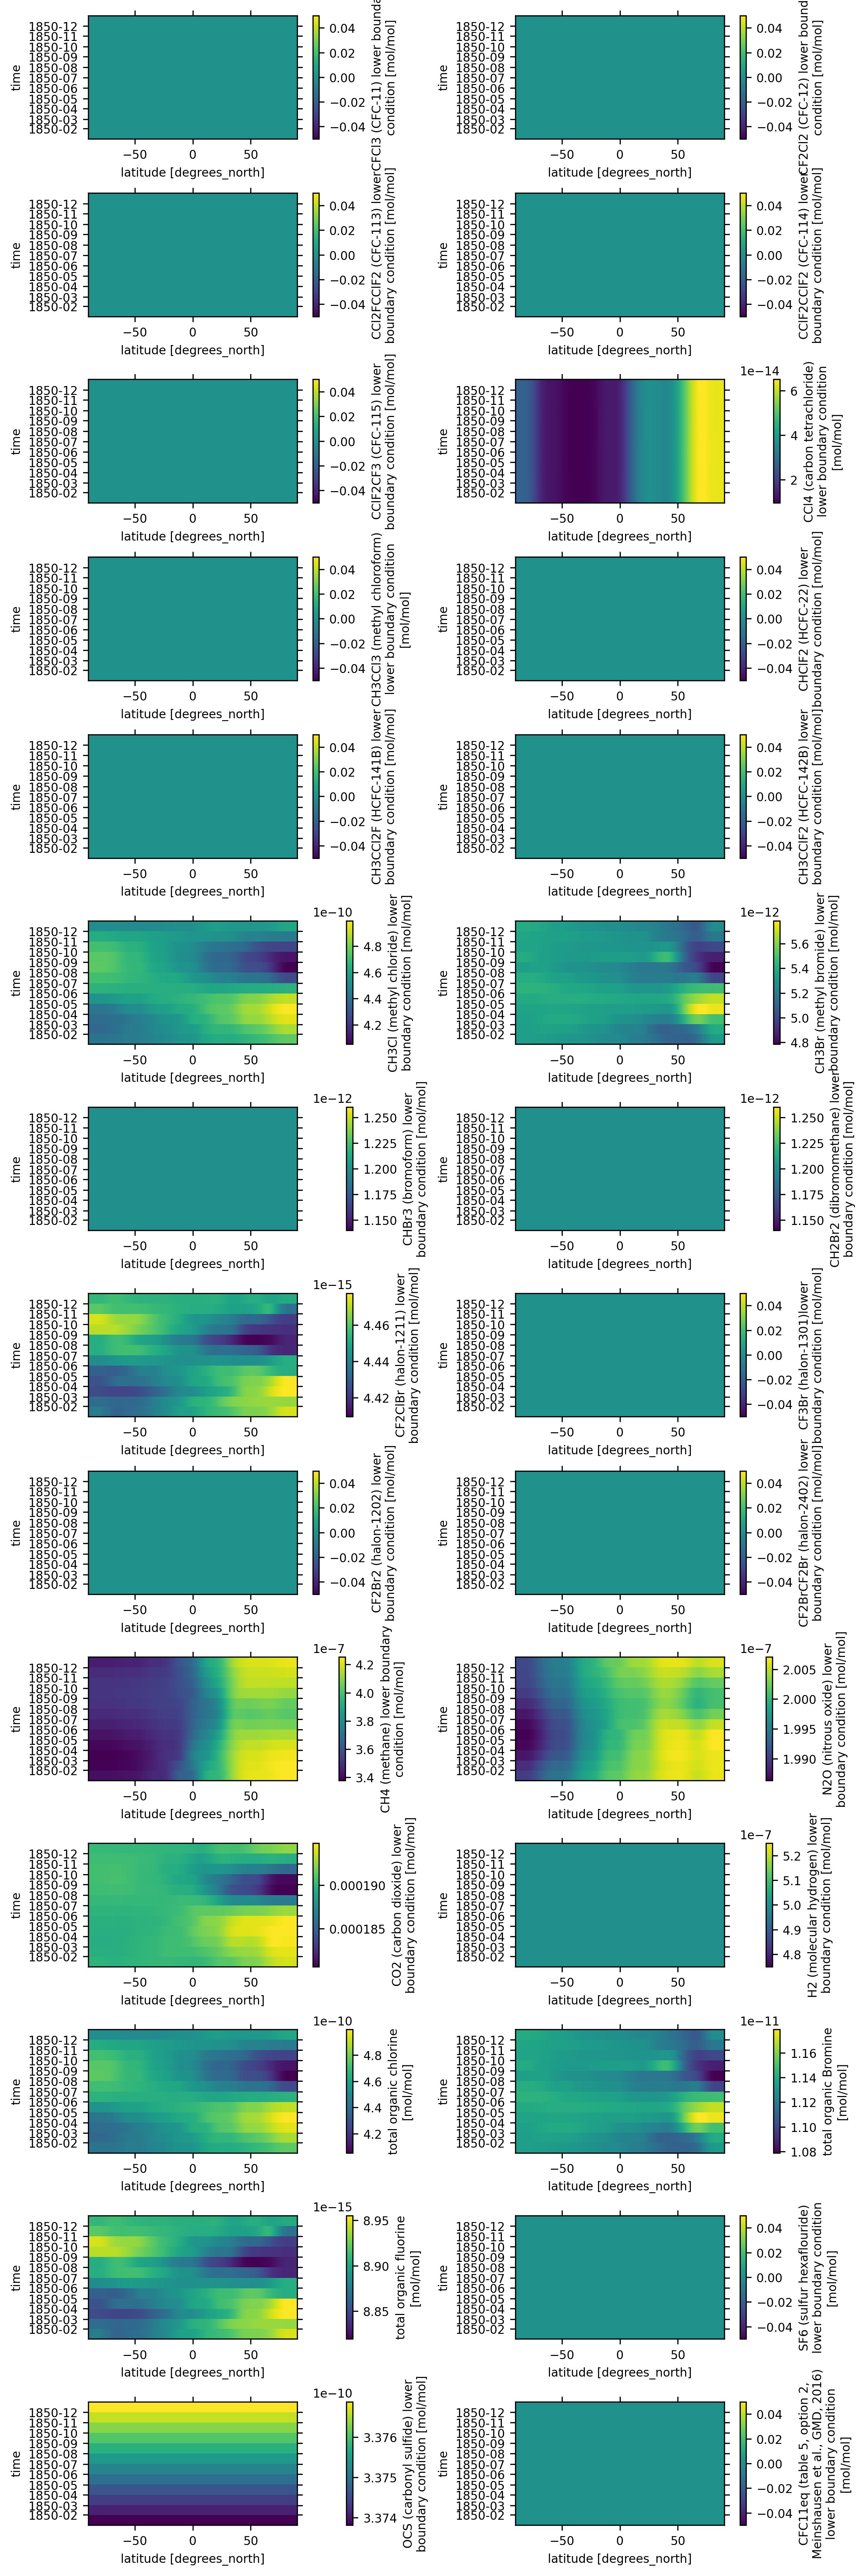

In [6]:
fig, axes = plt.subplots(14, 2, figsize=(8, 24),
                         sharex=False, sharey=False,
                         dpi=300,
                         constrained_layout=True)

var_list = ds_lbc_lgm.keys()
var_list = [item for item in var_list if item[:4] != 'time']
var_list = [item for item in var_list if item[:4] != 'date']

for ax, vname in zip(axes.ravel(), var_list):
        ds_lbc_lgm[vname].plot(ax=ax)